<a href="https://colab.research.google.com/github/MahlerTom/LiverSegmentation/blob/master/deep_learning_medical_imaging_Tom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

The dataset was uploaded to [MahlerTom/LiverSegmentation](https://github.com/MahlerTom/LiverSegmentation), so we first need to clone the repository, with the data. To make things easier, we also define:

*   `repo_path` - the repository path (this should be cross platrform since we use `os` module)
*   `train_path` - the train dataset path
*   `val_path` - the test dataset path



In [1]:
import os

# Clone the entire repo.
!git clone -s git://github.com/MahlerTom/LiverSegmentation.git
repo_path = os.path.join(os.getcwd(), 'LiverSegmentation')
train_path = os.path.join(repo_path, 'data', 'train')
val_path = os.path.join(repo_path, 'data', 'val')

Cloning into 'LiverSegmentation'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 3242 (delta 13), reused 23 (delta 6), pack-reused 3212
Receiving objects: 100% (3242/3242), 263.81 MiB | 38.47 MiB/s, done.
Resolving deltas: 100% (112/112), done.
Checking out files: 100% (6375/6375), done.


# Preparing the dataset

Before we begin our training, we need to prepare the dataset. Since we are using TensorFlow 2.0, we will make use of its functions. We followed the guide at: [https://www.tensorflow.org/alpha/tutorials/load_data/images](https://www.tensorflow.org/alpha/tutorials/load_data/images)

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
# tf.enable_eager_execution()
print(tf.VERSION)
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.test.is_gpu_available()

1.13.1


True

## Prepare data paths
Tensorflow makes use of smart functions that can load images given their paths.

In [0]:
import random
import IPython.display as display

def load_data(data_path, print_imgs=3):
  import pathlib
  
  data_root = pathlib.Path(data_path)
  
  data_paths = list(data_root.glob('*'))
  data_paths = [str(path) for path in data_paths]
#   random.shuffle(data_paths)
  data_count = len(data_paths)
  print('Loaded', data_count, 'image paths')  

  if print_imgs > 0:
    print('##########################################')
    print('Printing Example Images')
    print()
    
    for n in range(print_imgs):
      image_path = random.choice(data_paths)
      display.display(display.Image(image_path))
      print(image_path.split('/')[-1][:-4])
      print()
      
    print('##########################################')
    
  rel_path = os.path.join('/', *data_paths[0].split('/')[:-1])

  return data_paths

def image_name(path):
  return path.split('/')[-1][:-4]

In [4]:
train_images_paths = load_data(os.path.join(train_path, 'images'), print_imgs=0)
train_masks_paths = load_data(os.path.join(train_path, 'masks'), print_imgs=0)

val_images_paths = load_data(os.path.join(val_path, 'images'), print_imgs=0)
val_masks_paths = load_data(os.path.join(val_path, 'masks'), print_imgs=0)

Loaded 1092 image paths
Loaded 1092 image paths
Loaded 500 image paths
Loaded 500 image paths


## Load and Preprocess image using TF
These function loads images as tensors, and lay the groundwork for preprocessing

In [0]:
def preprocess_image(img_raw, norm=None, resize=None):
  img_tensor = tf.image.decode_png(img_raw, channels=1)
#   print(img_tensor.shape)
#   print(img_tensor.dtype)

  if resize is not None:
    img_tensor = tf.image.resize(img_tensor, resize) # [192, 192]
#     print(img_tensor.shape)
  if norm is not None:
    img_tensor /= norm # 255.0
#     print(img_tensor.numpy().min())
#     print(img_tensor.numpy().max())
  return img_tensor
  
def load_and_preprocess_image(img_path, norm=None, resize=None):
  img_raw = tf.read_file(img_path)
#   print(repr(img_raw)[:100]+"...")
  return preprocess_image(img_raw, norm=norm, resize=resize)

def load_and_preprocess_from_path_label(paths, label, norm=None, resize=None):
  return load_and_preprocess_image(paths, norm=norm, resize=resize), load_and_preprocess_image(label, norm=norm, resize=resize)

### Testing `load_and_preprocess_image` [collapse]

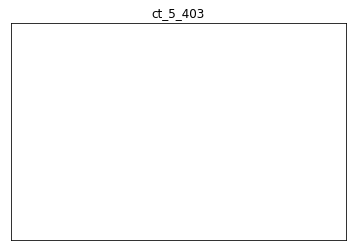

In [6]:
import matplotlib.pyplot as plt
import numpy as np

img_path = train_images_paths[0]

# plt.imshow(np.squeeze(load_and_preprocess_image(img_path, norm=255.0, resize=[224, 224])), cmap='gray', vmin=0, vmax=1)
plt.grid(False)
plt.title(image_name(img_path))
plt.xticks([])
plt.yticks([])
print()

## Creating Datasets using `tf.data.Dataset.from_tensor_slices`

In [0]:
def create_image_ds(image_paths, norm=None, resize=None):
  path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
  # print(path_ds)
  image_ds = path_ds.map(lambda path: load_and_preprocess_image(path, norm=norm, resize=resize), num_parallel_calls=AUTOTUNE)
  return image_ds

def create_ds(image_paths, mask_paths, norm=None, resize=None):
  ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
  label_ds = ds.map(
      lambda paths, label: load_and_preprocess_from_path_label(paths, label, norm=norm, resize=resize), 
      num_parallel_calls=AUTOTUNE
  )
  return label_ds

### Testing `create_image_ds` [collapse]

In [8]:
import matplotlib.pyplot as plt

path_ds = tf.data.Dataset.from_tensor_slices(train_images_paths)
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

image_ds = create_image_ds(train_images_paths, norm=255.0, resize=[224, 224])
print(image_ds)

plt.figure(figsize=(8,8))
# for n, image in enumerate(image_ds.take(4)):
#   plt.subplot(2,2,n+1)
#   plt.imshow(np.squeeze(image), cmap='gray', vmin=0, vmax=1)
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])
#   plt.xlabel(image_name(train_images_paths[n]))
#   plt.show()

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>
<DatasetV1Adapter shapes: (224, 224, 1), types: tf.float32>


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

### Loading Datasets and labels


In [9]:
# resize=[256, 256]
resize=[128, 128]

norm=255.0
# train_ds_images = create_image_ds(train_images_paths, norm=norm, resize=resize)
# train_ds_masks = create_image_ds(train_masks_paths, norm=norm, resize=resize)
# train_ds = tf.data.Dataset.zip((train_ds_images, train_ds_masks))
# print(train_ds)
train_ds = create_ds(train_images_paths, train_masks_paths, norm=norm, resize=resize)
print(train_ds)

# val_ds_images = create_image_ds(val_images_paths, norm=norm, resize=resize)
# val_ds_masks = create_image_ds(val_masks_paths, norm=norm, resize=resize)
# val_ds = tf.data.Dataset.zip((val_ds_images, val_ds_masks))
val_ds = create_ds(val_images_paths, val_masks_paths, norm=norm, resize=resize)
print(val_ds)

<DatasetV1Adapter shapes: ((128, 128, 1), (128, 128, 1)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((128, 128, 1), (128, 128, 1)), types: (tf.float32, tf.float32)>


## Basic methods for training
To train a model with this dataset you will want the data:

*   To be well shuffled.
*   To be batched.
*   To repeat forever.
*   Batches to be available as soon as possible.

These features can be easily added using the tf.data api.

In [0]:
def prepare_ds(ds, batch_size, buffer_size, shuffle=True):
  # Setting a shuffle buffer size as large as the dataset ensures that the data is
  # completely shuffled.
  if shuffle:
    ds = ds.shuffle(buffer_size=buffer_size)
  ds = ds.repeat()
  ds = ds.batch(batch_size=batch_size)
  
  # `prefetch` lets the dataset fetch batches, in the background while the model is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# def split_train_val(ds_pre, ds_len, val_size=.3):
#   val_ds_pre_len = int(val_size * ds_len)
#   val_ds_pre = ds_pre.take(val_ds_pre_len)
#   train_ds_pre = ds_pre.skip(val_ds_pre_len)
#   return train_ds_pre, val_ds_pre

In [11]:
BATCH_SIZE = 32

train_ds = prepare_ds(train_ds, batch_size=BATCH_SIZE, buffer_size=len(train_images_paths))
print(train_ds)
val_ds = prepare_ds(val_ds, batch_size=BATCH_SIZE, buffer_size=len(val_images_paths))
print(val_ds)


<DatasetV1Adapter shapes: ((?, 128, 128, 1), (?, 128, 128, 1)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((?, 128, 128, 1), (?, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [12]:
tmp_ds = create_ds(val_images_paths, val_masks_paths, norm=norm, resize=resize)
tmp_ds = prepare_ds(tmp_ds, batch_size=1, buffer_size=len(val_images_paths), shuffle=False)
print(tmp_ds)

<DatasetV1Adapter shapes: ((?, 128, 128, 1), (?, 128, 128, 1)), types: (tf.float32, tf.float32)>


# Define the model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# from keras import backend as keras

def unet(pretrained_weights=None, shape=(256,256,1), filters=64):
    
    # First 3 layers
    inputs = Input(shape=shape, name='input') 
    conv1 = Conv2D(
        filters=filters,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv1_1'
    )(inputs)   
    conv1 = Conv2D(
        filters=filters, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv1_2'
    )(conv1)
    
    # Second 3 layers
    pool1 = MaxPooling2D(
        pool_size=(2, 2),
        name='pool2_0'
    )(conv1)
    conv2 = Conv2D(
        filters=filters*2, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv2_1'
    )(pool1)
    conv2 = Conv2D(
        filters=filters*2,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2_2'
    )(conv2)
    
    # Third 3 layers
    pool2 = MaxPooling2D(
        pool_size=(2, 2),
        name='pool3_0'
    )(conv2)
    conv3 = Conv2D(
        filters=filters*4, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv3_1'
    )(pool2)
    conv3 = Conv2D(
        filters=filters*4, 
        kernel_size=3, 
        activation='relu',
        padding='same', 
        kernel_initializer='he_normal',
        name='conv3_2'
    )(conv3)
    
    # Fourth 3 layers
    pool3 = MaxPooling2D(
        pool_size=(2, 2),
        name='pool4_0'
    )(conv3)
    conv4 = Conv2D(
        filters=filters*8, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv4_1'
    )(pool3)
    conv4 = Conv2D(
        filters=filters*8,
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv4_2'
    )(conv4)
    
    # Fifth Dropout layers
    drop4 = Dropout(
        rate=0.5,
        name='drop5_0'
    )(conv4)
    
    # Fifth 3 layers
    pool4 = MaxPooling2D(
        pool_size=(2, 2),
        name='pool5_0'
    )(drop4)
    conv5 = Conv2D(
        filters=filters*16, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv5_1'
    )(pool4)
    conv5 = Conv2D(
        filters=filters*16, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv5_1'
    )(conv5)
    
    # sixth Dropout layers
    drop5 = Dropout(
        rate=0.5,
        name='drop6_0'
    )(conv5)
    
    # seventh concat layer
    up6 = Conv2D(
        filters=filters*8, 
        kernel_size=(2, 2), 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv7_concat'
    )(UpSampling2D(
        size=(2, 2),
        name='up7_concat'
    )(drop5))
    merge6 = concatenate(
        [drop4, up6], 
        axis=3,
        name='concat7_0'
    )
        
    # Rest of seventh layer
    conv6 = Conv2D(
        filters=filters*8, 
        kernel_size=3, 
        activation='relu', 
        padding='same',
        kernel_initializer='he_normal',
        name='conv7_1'
    )(merge6)
    conv6 = Conv2D(
        filters=filters*8, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv7_2'
    )(conv6)

    # Eighth concat layer
    up7 = Conv2D(
        filters=filters*4, 
        kernel_size=2, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv8_concat'
    )(UpSampling2D(
        size=(2,2),
        name='up8_concat'
    )(conv6))
    merge7 = concatenate(
        [conv3,up7],
        axis=3,
        name='concat8_0'
    )
    
    # Rest of eighth layer
    conv7 = Conv2D(
        filters=filters*4, 
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv8_1'
    )(merge7)
    conv7 = Conv2D(
        filters=filters*4, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv8_2'
    )(conv7)

    # Ninth concat layer
    up8 = Conv2D(
        filters=filters*2, 
        kernel_size=2, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv9_concat'
    )(UpSampling2D(
        size=(2,2),
        name='up9_concat'
    )(conv7))
    merge8 = concatenate(
        [conv2,up8], 
        axis=3,
        name='concat9_0'
    )
    
    # Rest of Ninth layer
    conv8 = Conv2D(
        filters=filters*2, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv9_1'
    )(merge8)
    conv8 = Conv2D(
        filters=filters*2, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv9_2'
    )(conv8)

    # Tenth concat layer
    up9 = Conv2D(
        filters=filters, 
        kernel_size=2, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv10_concat'
    )(UpSampling2D(
        size=(2,2),
        name='up10_concat'
    )(conv8))
    merge9 = concatenate(
        [conv1,up9],
        axis=3,
        name='concat10_0'
    )
    
    # Rest of Tenth layer
    conv9 = Conv2D(
        filters=filters,
        kernel_size=3,
        activation='relu',
        padding='same', 
        kernel_initializer='he_normal',
        name='conv10_1'
    )(merge9)
    conv9 = Conv2D(
        filters=filters, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv10_2'
    )(conv9)
    conv9 = Conv2D(
        filters=2, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        kernel_initializer='he_normal',
        name='conv10_3'
    )(conv9)
    
    
    conv10 = Conv2D(
        filters=1, 
        kernel_size=(1, 1), 
        activation='sigmoid', 
        name='output'
    )(conv9)

    model = Model(inputs, conv10, name="unet")
       
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Define loss function and metrices

In [0]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = 2*TP/ (2TP + FP + FN)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    return (2. * intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred) 

## Prepare Tensorboard [collapse]

In [15]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook

# Clear any logs from previous runs
!rm -rf ./logs/

LOG_DIR = 'logs/fit'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')


--2019-05-25 10:41:52--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.54.84.112, 34.199.255.1, 34.206.130.40, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.54.84.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.88M  18.6MB/s    in 0.9s    

2019-05-25 10:41:53 (18.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


### tmp

In [0]:
from tensorflow.keras.callbacks import TensorBoard

class OurTensorBoard(TensorBoard):
#     def __init__(self, log_dir='./logs', **kwargs):
#         # Make the original `TensorBoard` log to a subdirectory 'training'
#         super(OurTensorBoard, self).__init__(training_log_dir, **kwargs)

#         # Log the validation metrics to a separate subdirectory
#         self.val_log_dir = os.path.join(log_dir, 'validation')

#     def set_model(self, model):
#         # Setup writer for validation metrics
#         self.val_writer = tf.summary.FileWriter(self.val_log_dir)
#         super(OurTensorBoard, self).set_model(model)
    
#     def on_batch_end(self, batch, logs=None):
#       super(TrainValTensorBoard, self).on_batch_end(batch, logs)
   
#     def on_epoch_begin(self, epoch, logs=None):
#       super(TrainValTensorBoard, self).on_epoch_begin(epoch, logs)

#     def on_epoch_end(self, epoch, logs=None):
#       super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)
    
    def on_epoch_end(self, epoch, logs=None):
      for i in tmp_ds.take(1):
        print(i[0].shape)
        pred = model.predict(
            i[0],
#             batch_size=1,
            verbose=1,
#           steps=None,
#           max_queue_size=10,
#           workers=1,
#           use_multiprocessing=False
        )
        print(pred)
      
      super(OurTensorBoard, self).on_epoch_end(epoch, logs)

#     def on_epoch_end(self, epoch, logs=None):
#       print(self)
      
#       super(OurTensorBoard, self).on_epoch_end(epoch, logs)

#     def on_train_end(self, logs=None):
#         super(TrainValTensorBoard, self).on_train_end(logs)
#         self.val_writer.close()

## Compile Model

In [0]:
# For using tensorboard externally with ngrok
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# For using tensorboard locally in notebook
%tensorboard --logdir logs/fit

In [0]:
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

input_shape = (resize[0], resize[1], 1)
filters = 8
optimizer = Adam(lr=5e-3)
steps_per_epoch = int(len(train_images_paths)/BATCH_SIZE)
validation_steps = int(len(val_images_paths)/BATCH_SIZE)
print('steps_per_epoch =', steps_per_epoch, 'validation_steps =', validation_steps)

model = unet(shape=input_shape,filters=filters)
model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])

Instructions for updating:
Colocations handled automatically by placer.
steps_per_epoch = 34 validation_steps = 15
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Print model information [collapse]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

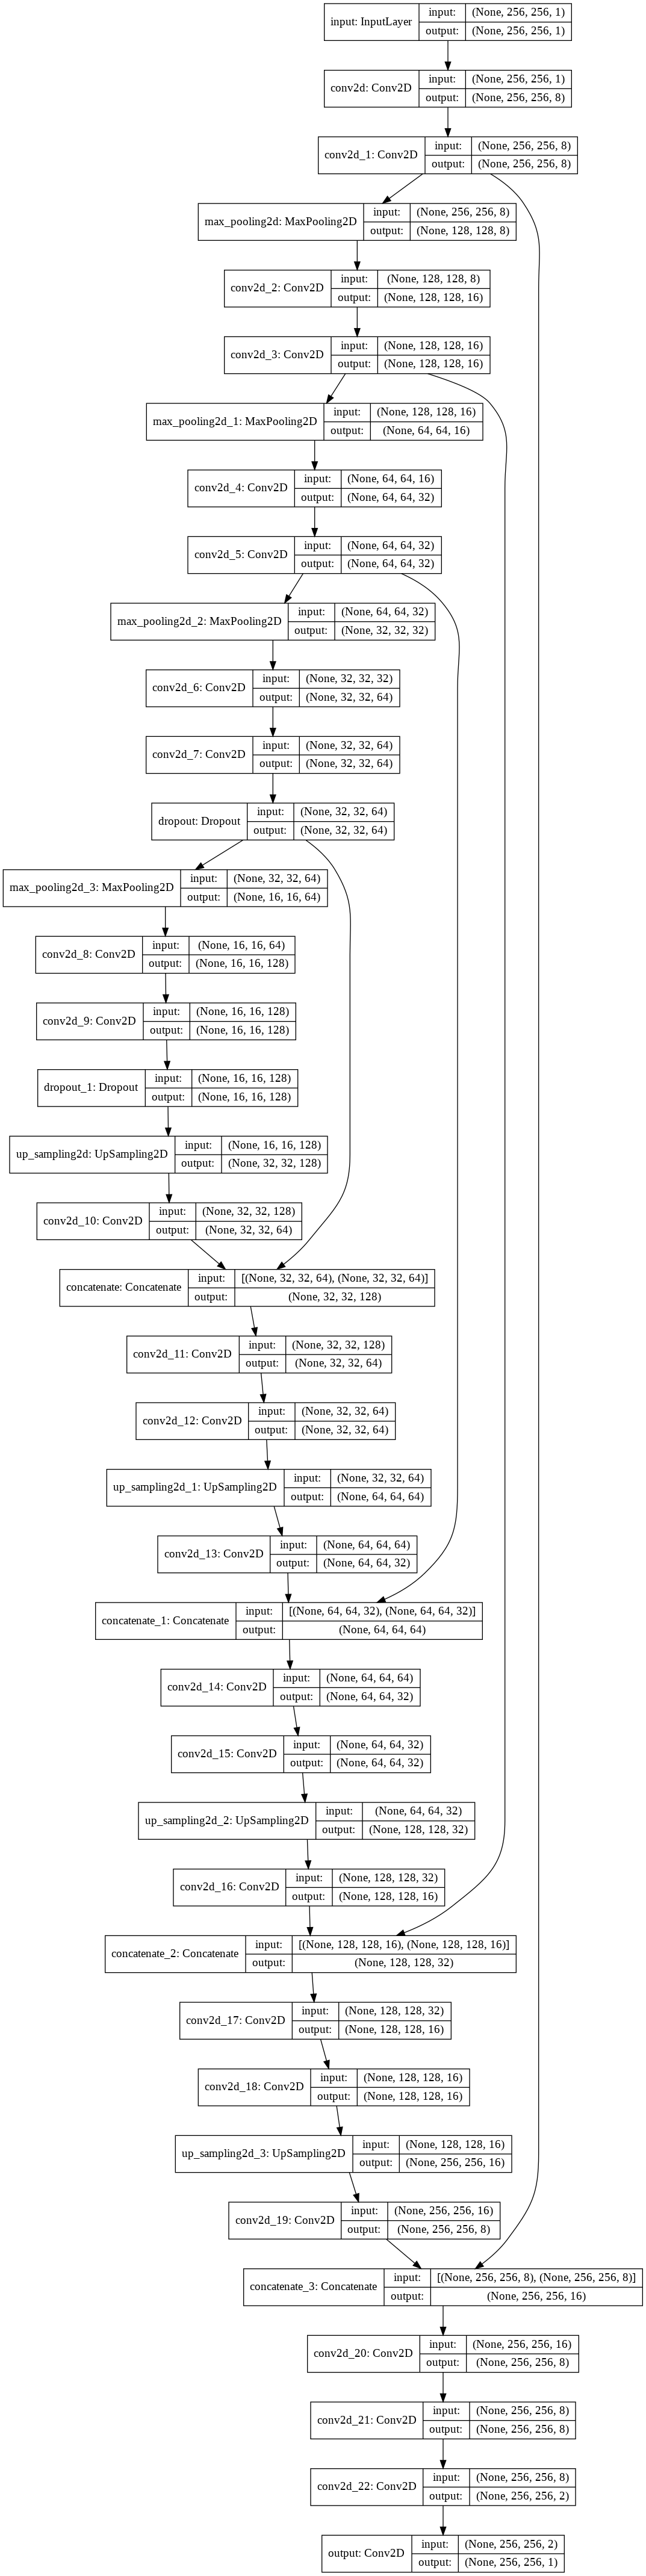

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, 'Siamese Network Architecture.png', show_shapes=True)
display.display(display.Image('Siamese Network Architecture.png'))

## Fit model and evaluate model

In [22]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir="logs/fit/" + datetime.datetime.now().strftime("%m%d-%H%M%S")
  

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    batch_size=BATCH_SIZE,
#     write_graph=True,
#     write_grads=False,
    write_images=True
#     embeddings_freq=0,
#     embeddings_layer_names=None,
#     embeddings_metadata=None,
#     embeddings_data=None,
#     update_freq='epoch'
)

callbacks=[ tensorboard_callback ]

model.fit(
    train_ds,
#     batch_size=BATCH_SIZE,
    epochs=100, #epochs=200,
    verbose=1,
    callbacks=callbacks,
#     validation_split=0.0,
    validation_data=val_ds,
#     shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epoch=0,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False,
#     **kwargs
)

Epoch 1/100
34/34 [==============================] - 112s 3s/step - loss: 0.6763 - dice_coef: 0.3237 - val_loss: 0.4529 - val_dice_coef: 0.5471
Epoch 2/100
34/34 [==============================] - 92s 3s/step - loss: 0.4471 - dice_coef: 0.5529 - val_loss: 0.3727 - val_dice_coef: 0.6273
Epoch 3/100
34/34 [==============================] - 97s 3s/step - loss: 0.4071 - dice_coef: 0.5929 - val_loss: 0.4046 - val_dice_coef: 0.5954
Epoch 4/100
34/34 [==============================] - 95s 3s/step - loss: 0.3928 - dice_coef: 0.6072 - val_loss: 0.4013 - val_dice_coef: 0.5987
Epoch 5/100
34/34 [==============================] - 94s 3s/step - loss: 0.3885 - dice_coef: 0.6115 - val_loss: 0.3438 - val_dice_coef: 0.6562
Epoch 6/100
34/34 [==============================] - 94s 3s/step - loss: 0.3804 - dice_coef: 0.6196 - val_loss: 0.3496 - val_dice_coef: 0.6504
Epoch 7/100
34/34 [==============================] - 93s 3s/step - loss: 0.3806 - dice_coef: 0.6194 - val_loss: 0.3280 - val_dice_coef: 0.672

KeyboardInterrupt: ignored

In [0]:
callbacks = [
#     TensorBoardColabCallback(tbc)
    tbCallBack
]

model.fit(
    train_ds,
#     batch_size=BATCH_SIZE,
    epochs=20, #epochs=200,
    verbose=1,
    callbacks=callbacks,
#     validation_split=0.0,
    validation_data=val_ds,
#     shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epoch=0,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False,
#     **kwargs
)

Epoch 1/20
34/34 [==============================] - 122s 4s/step - loss: 0.8381 - dice_coef: 0.1619 - val_loss: 0.8491 - val_dice_coef: 0.1509
Epoch 2/20
34/34 [==============================] - 107s 3s/step - loss: 0.8164 - dice_coef: 0.1836 - val_loss: 0.8387 - val_dice_coef: 0.1613
Epoch 3/20
34/34 [==============================] - 104s 3s/step - loss: 0.8072 - dice_coef: 0.1928 - val_loss: 0.8398 - val_dice_coef: 0.1602
Epoch 4/20
34/34 [==============================] - 102s 3s/step - loss: 0.8025 - dice_coef: 0.1975 - val_loss: 0.8325 - val_dice_coef: 0.1675
Epoch 5/20
34/34 [==============================] - 103s 3s/step - loss: 0.7963 - dice_coef: 0.2037 - val_loss: 0.8242 - val_dice_coef: 0.1758
Epoch 6/20
34/34 [==============================] - 101s 3s/step - loss: 0.7922 - dice_coef: 0.2078 - val_loss: 0.8183 - val_dice_coef: 0.1817
Epoch 7/20
34/34 [==============================] - 101s 3s/step - loss: 0.7868 - dice_coef: 0.2132 - val_loss: 0.8191 - val_dice_coef: 0.1809

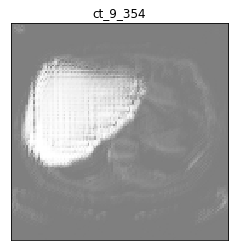

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# img_path = train_images_paths[0]

plt.imshow(np.squeeze(pred[0,:,:,:]), cmap='gray', vmin=0, vmax=1)
plt.grid(False)
plt.title(image_name(val_images_paths[1]))
plt.xticks([])
plt.yticks([])
print()

In [0]:
pred = model.predict(
    tmp_ds,
    batch_size=1,
    verbose=1,
    steps=len(val_images_paths),
#           max_queue_size=10,
#           workers=1,
#           use_multiprocessing=False
)
print(pred.shape)

500/500 [==============================] - 4s 7ms/step
(500, 128, 128, 1)


In [0]:
for i in tmp_ds.take(1000):
  print(i[0].shape)
  pred = model.predict(
      i[0],
      batch_size=1,
      verbose=1,
#       steps=5,
  #           max_queue_size=10,
  #           workers=1,
  #           use_multiprocessing=False
  )
  print(pred)

RuntimeError: ignored

In [0]:
for i in tmp_ds.take(1000):
  print(i[0].shape)
  pred = model.predict(
      i[0],
      batch_size=1,
      verbose=1,
#       steps=5,
  #           max_queue_size=10,
  #           workers=1,
  #           use_multiprocessing=False
  )
  print(pred)

RuntimeError: ignored

In [0]:
pred = model.predict(
    load_and_preprocess_image(val_images_paths[0], norm=norm, resize=resize).numpy(),
#     batch_size=32,
    verbose=1,
#     steps=15,
  #           max_queue_size=10,
  #           workers=1,
  #           use_multiprocessing=False
  )
print(pred)

ValueError: ignored

# other

In [0]:
model = unet(input_size=(256,256,1), filter_size=2, optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

callbacks = [ ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True) ]
model.fit(
    train_ds, 
    batch_size=32, 
    epochs=2, 
    verbose=2, 
#     callbacks=callbacks, 
    shuffle=True, 
    steps_per_epoch=200, 
    validation_data=val_ds, 
    validation_steps=200,
)
# model.fit_generator(myGene,steps_per_epoch=300,epochs=1,callbacks=[model_checkpoint])

# testGene = testGenerator("data/membrane/test")
# results = model.predict_generator(testGene,30,verbose=1)
# saveResult("data/membrane/test",results)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/2
Instructions for updating:
Use tf.cast instead.
200/200 [==============================] - 5s 26ms/step - loss: 0.1212 - dice_coef: 0.9962
 - 28s - loss: 1.8503 - dice_coef: 0.9422 - val_loss: 0.1212 - val_dice_coef: 0.9962
Epoch 2/2
200/200 [==============================] - 5s 26ms/step - loss: 0.0836 - dice_coef: 0.9974
 - 22s - loss: 0.0679 - dice_coef: 0.9979 - val_loss: 0.0836 - val_dice_coef: 0.9974


In [0]:
import cv2
import random
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
 
# def batch_generator(ds, batch_size):
#   while True:      
#         image_list = []
#         mask_list = []
#         for i in range(batch_size):
#             img, mask = gen_random_image()
#             image_list.append(img)
#             mask_list.append([mask])

#         image_list = np.array(image_list, dtype=np.float32)
#         if K.image_dim_ordering() == 'th':
#             image_list = image_list.transpose((0, 3, 1, 2))
#         image_list = preprocess_input(image_list)
#         mask_list = np.array(mask_list, dtype=np.float32)
#         mask_list /= 255.0
#         yield image_list, mask_list


def train_unet(model, train_ds, val_ds, epochs=200, patience=20, batch_size=16, optim_type='SGD', learning_rate=0.001, out_model_path='zf_unet_224.h5'):  
    if os.path.isfile(out_model_path):
        model.load_weights(out_model_path)

    if optim_type == 'SGD':
        optim = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    else:
        optim = Adam(lr=learning_rate)
    model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef])

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, epsilon=0.00001, verbose=1, mode='min'),
        # EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
        ModelCheckpoint('zf_unet_224_temp.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]

    print('Start training...')
    history = model.fit_generator(
        generator=train_ds.take(batch_size),
        epochs=epochs,
        steps_per_epoch=200,
        validation_data=val_ds.take(batch_size),
        validation_steps=200,
        verbose=2,
        callbacks=callbacks)

    model.save_weights(out_model_path)
    pd.DataFrame(history.history).to_csv('zf_unet_224_train.csv', index=False)
    print('Training is finished (weights zf_unet_224.h5 and log zf_unet_224_train.csv are generated )...')

 - 7s


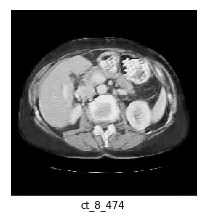

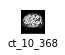

In [0]:
plt.figure(figsize=(32,32))
n=1
for image in val_ds.take(1):
  pred = model.predict(image, batch_size=32, verbose=2, steps=200)
  plt.subplot(8,8,n)
  n+=1
  plt.imshow(np.squeeze(pred[0,:,:,:]), cmap='gray', vmin=0, vmax=1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(image_name(val_images_paths[n]))
  plt.show()
  plt.subplot(8,8,n)
  n+=1
  plt.imshow(np.squeeze(pred[0,:,:,:]), cmap='gray', vmin=0, vmax=1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(image_name(val_images_paths[n]))
  plt.show()
  
  


In [0]:
pred[0,:,:,:].shape

(256, 256, 1)

In [0]:
from tensorflow.keras.optimizers import Adam

model = ZF_UNET_224(weights='generator')
optim = Adam()
model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef])
# model.summary()

callbacks = [
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, epsilon=0.00001, verbose=1, mode='min'),
    # EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
    ModelCheckpoint('zf_unet_224_temp.h5', monitor='val_loss', save_best_only=True, verbose=0),
]

model.fit(
    train_ds, 
    batch_size=16, 
    epochs=200, 
    verbose=2, 
#     callbacks=callbacks, 
    shuffle=True, 
    steps_per_epoch=200, 
#     validation_data=val_ds, 
#     validation_steps=200,
)

# model.fit(...)

Epoch 1/200


InvalidArgumentError: ignored

In [0]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, SpatialDropout2D, Activation, concatenate
# from tensorflow.keras import backend as K
# from tensorflow.keras.utils import get_file

# # Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
# INPUT_CHANNELS = 1
# # Number of output masks (1 in case you predict only one type of objects)
# OUTPUT_MASK_CHANNELS = 2
# # Pretrained weights
# ZF_UNET_224_WEIGHT_PATH = 'https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model/releases/download/v1.0/zf_unet_224.h5'


# def preprocess_input(x):
#     x /= 256
#     x -= 0.5
#     return x


# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


# def jacard_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


# def jacard_coef_loss(y_true, y_pred):
#     return -jacard_coef(y_true, y_pred)


# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)


# def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
# #     if K.image_dim_ordering() == 'th':
# #         axis = 1
# #     else:
#     axis = 3
#     conv = Conv2D(size, (3, 3), padding='same')(x)
#     if batch_norm is True:
#         conv = BatchNormalization(axis=axis)(conv)
#     conv = Activation('relu')(conv)
#     conv = Conv2D(size, (3, 3), padding='same')(conv)
#     if batch_norm is True:
#         conv = BatchNormalization(axis=axis)(conv)
#     conv = Activation('relu')(conv)
#     if dropout > 0:
#         conv = SpatialDropout2D(dropout)(conv)
#     return conv

## Pipe the dataset to a model

# Other

In [0]:
# !git clone https://github.com/MahlerTom/tf_unet.git
!git clone https://github.com/jakeret/tf_unet.git

%cd tf_unet
!pip install -r requirements.txt
!python setup.py install --user
%cd ..

fatal: destination path 'tf_unet' already exists and is not an empty directory.
/content/tf_unet


KeyboardInterrupt: ignored

In [0]:
model

In [0]:
from tf_unet import unet, util, image_util


#preparing data loading
data_provider = image_util.ImageDataProvider(
    '/content/LiverSegmentation/data/flat_train/*.png',
    data_suffix=u'.png',
    mask_suffix=u'_mask.png',
    color=False,
)
#setup & training
net = unet.Unet(layers=3, features_root=64, channels=1, n_class=3)
trainer = unet.Trainer(net)
path = trainer.train(data_provider, output_path='/content/output/', training_iters=5, epochs=1) #training_iters=32, epochs=100
#verification
# ...



2019-05-22 13:50:08,027 Layers 3, features 64, filter size 3x3, pool size: 2x2


Number of files used: 1092
Number of channels: 3
Number of classes: 3
Instructions for updating:
Colocations handled automatically by placer.


2019-05-22 13:50:08,051 From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-05-22 13:50:08,095 From /content/tf_unet/tf_unet/layers.py:39: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2019-05-22 13:50:09,787 Removing '/content/tf_unet/prediction'
2019-05-22 13:50:09,789 Removing '/content/output'
2019-05-22 13:50:09,790 Allocating '/content/tf_unet/prediction'
2019-05-22 13:50:09,794 Allocating '/content/output'


ValueError: ignored

In [0]:
prediction = net.predict(path, data_provider)

unet.error_rate(prediction, util.crop_to_shape(label, prediction.shape))

img = util.combine_img_prediction(data_provider, label, prediction)
util.save_image(img, "prediction.jpg")

Instructions for updating:
Use standard file APIs to check for files with this prefix.


2019-05-18 17:07:17,032 From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /content/output/model.ckpt


2019-05-18 17:07:17,047 Restoring parameters from /content/output/model.ckpt
2019-05-18 17:07:17,171 Model restored from file: /content/output/model.ckpt


AttributeError: ignored

In [0]:
!ls

LiverSegmentation  output  prediction  sample_data  tf_unet


In [0]:
from PIL import Image
import numpy as np

tmp = np.array(Image.open('/content/LiverSegmentation/data/tmp/ct_0_46.png').convert('L'), dtype=np.float32)
tmp.shape

(512, 512)

In [0]:
tmp[:,:,0] == tmp[:,:,1]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

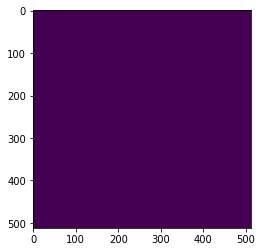

In [0]:
import matplotlib.pyplot as plt
plt.imshow(tmp[:,:,1])

Loaded 1092 images paths
##########################################
Printing Example Images For images



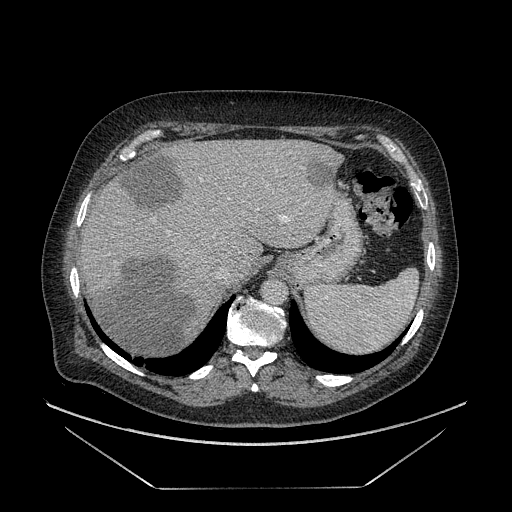

ct_4_509



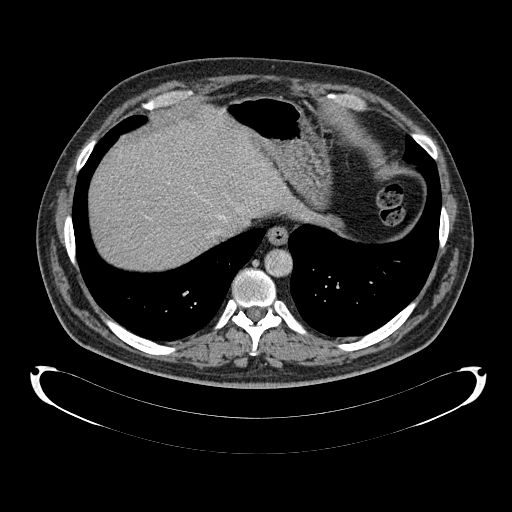

ct_6_462



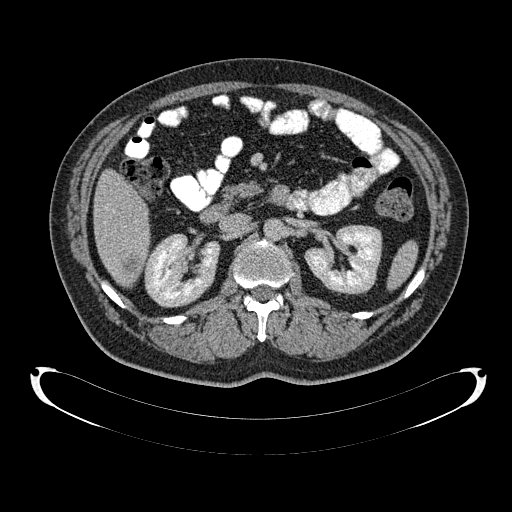

ct_6_341

##########################################
Loaded 1092 masks paths
##########################################
Printing Example Images For masks



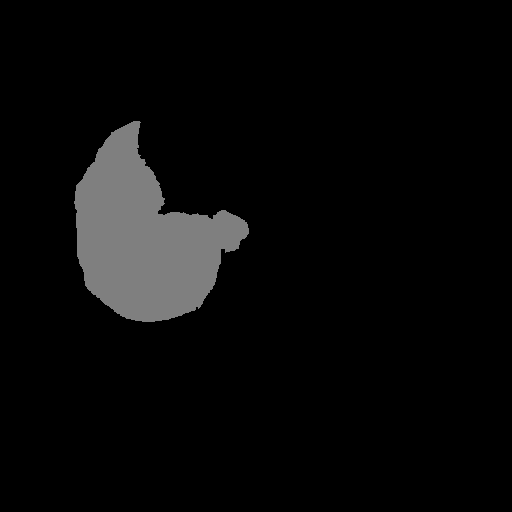

seg_6_419



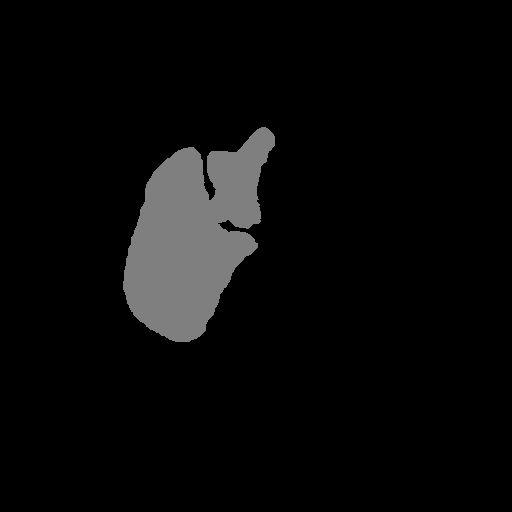

seg_5_414



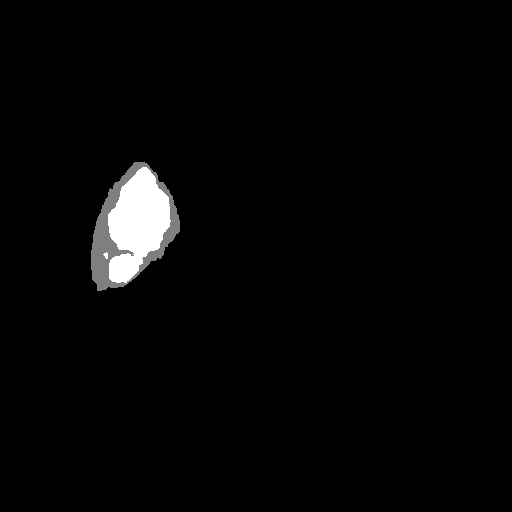

seg_4_406

##########################################
['ct_5_425', 'ct_2_365', 'ct_7_402']
['content/LiverSegmentation/data/train/images/ct_5_425.jpg', 'content/LiverSegmentation/data/train/images/ct_2_365.jpg', 'content/LiverSegmentation/data/train/images/ct_7_402.jpg']
['seg_5_420', 'seg_4_381', 'seg_7_404']
['content/LiverSegmentation/data/train/masks/seg_5_420.jpg', 'content/LiverSegmentation/data/train/masks/seg_4_381.jpg', 'content/LiverSegmentation/data/train/masks/seg_7_404.jpg']


In [0]:
import pathlib
import random
import IPython.display as display

def load_images(data_path, print_imgs=3):
  def load_images_helper(subdir, data_path, print_imgs=3):
    data_root = pathlib.Path(os.path.join(data_path, subdir))
    data_paths = list(data_root.glob('*'))
    data_paths = [str(path) for path in data_paths]
    random.shuffle(data_paths)
    data_count = len(data_paths)
    print('Loaded', data_count, subdir, 'paths')
    if print_imgs > 0:
      print('##########################################')
      print('Printing Example Images For', subdir)
      print()

      for n in range(print_imgs):
        img_path = random.choice(data_paths)
        display.display(display.Image(img_path))
        print(img_path.split('/')[-1][:-4])
        print()

      print('##########################################')
    
    rel_path = os.path.join(*data_paths[0].split('/')[:-1])
    data_names = [ tip.split('/')[-1][:-4] for tip in data_paths ]
    data_paths_names_dict = { name: os.path.join(rel_path, name + '.jpg') for name in data_names }
    return data_paths_names_dict
  
  #   for subdir in ['images', 'masks']:
  imgs_paths_names_dict = load_images_helper(subdir='images', data_path=data_path, print_imgs=print_imgs)
  msks_paths_names_dict = load_images_helper(subdir='masks', data_path=data_path, print_imgs=print_imgs)
  return imgs_paths_names_dict, msks_paths_names_dict
  

  
train_imgs_paths_names_dict, msks_paths_names_dict = load_images(train_path, print_imgs=3)

for d in [train_imgs_paths_names_dict, msks_paths_names_dict]:
  print(list(d.keys())[:3])
  print(list(d.values())[:3])

In [0]:
import pathlib
import random
import IPython.display as display

def load_data(data_path, labels_file, print_imgs=3):
  data_root = pathlib.Path(data_path)
  
  data_paths = list(data_root.glob('*'))
  data_paths = [str(path) for path in data_paths]
  random.shuffle(data_paths)
  data_count = len(data_paths)
  print('Loaded', data_count, 'image paths')
  if print_imgs > 0:
    print('##########################################')
    print('Printing Example Images')
    print()
    
    for n in range(print_imgs):
      image_path = random.choice(data_paths)
      display.display(display.Image(image_path))
      print(image_path.split('/')[-1][:-4])
      print()
      
    print('##########################################')
    
  rel_path = os.path.join(*data_paths[0].split('/')[:-1])
  data_names = [ tip.split('/')[-1][:-4] for tip in data_paths ]
  data_paths_names_dict = { name: os.path.join(rel_path, name + '.jpg') for name in data_names }
    
  labels = list()
  with open(labels_file) as lf:
    for l in lf:
      l = l[:-1].split('\t')
      if len(l) == 3:
        labels.append(tuple((l[0] + '_' + l[1].zfill(4), l[0] + '_' + l[2].zfill(4), 1)))
      if len(l) == 4:
        labels.append(tuple((l[0] + '_' + l[1].zfill(4), l[2] + '_' + l[3].zfill(4), 0)))
        
  return data_paths_names_dict, labels


train_paths_names_dict, train_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'trainPairs.txt'))

test_paths_names_dict, test_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'testPairs.txt'))
print(list(train_paths_names_dict.keys())[:3])
print(list(train_paths_names_dict.values())[:3])
print(train_labels[:3])

LiverSegmentation  sample_data


In [0]:
import tensorflow as tf
import numpy as np,sys,os
from sklearn.utils import shuffle
from scipy.ndimage import imread
from scipy.misc import imresize
import matplotlib.pyplot as plt

np.random.seed(678)
tf.set_random_seed(5678)

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(s): return tf.cast(tf.greater(s,0),dtype=tf.float32)
def tf_softmax(x): return tf.nn.softmax(x)
def np_sigmoid(x): 1/(1 + np.exp(-1 *x))

# --- make class ---
class conlayer_left():
    
    def __init__(self,ker,in_c,out_c):
        self.w = tf.Variable(tf.random_normal([ker,ker,in_c,out_c],stddev=0.05))

    def feedforward(self,input,stride=1,dilate=1):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides = [1,stride,stride,1],padding='SAME')
        self.layerA = tf_relu(self.layer)
        return self.layerA

class conlayer_right():
    
    def __init__(self,ker,in_c,out_c):
        self.w = tf.Variable(tf.random_normal([ker,ker,in_c,out_c],stddev=0.05))

    def feedforward(self,input,stride=1,dilate=1,output=1):
        self.input  = input

        current_shape_size = input.shape

        self.layer = tf.nn.conv2d_transpose(input,self.w,
        output_shape=[batch_size] + [int(current_shape_size[1].value*2),int(current_shape_size[2].value*2),int(current_shape_size[3].value/2)],strides=[1,2,2,1],padding='SAME')
        self.layerA = tf_relu(self.layer)
        return self.layerA

# --- get data ---
data_location = "./DRIVE/training/images/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".tif" in filename.lower():  # check whether the file's DICOM
            train_data.append(os.path.join(dirName,filename))

data_location = "./DRIVE/training/1st_manual/"
train_data_gt = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".tif" in filename.lower():  # check whether the file's DICOM
            train_data_gt.append(os.path.join(dirName,filename))


train_images = np.zeros(shape=(128,256,256,1))
train_labels = np.zeros(shape=(128,256,256,1))

for file_index in range(len(train_data)):
    train_images[file_index,:,:]   = np.expand_dims(imresize(imread(train_data[file_index],mode='F',flatten=True),(256,256)),axis=2)
    train_labels[file_index,:,:]   = np.expand_dims(imresize(imread(train_data_gt[file_index],mode='F',flatten=True),(256,256)),axis=2)

train_images = (train_images - train_images.min()) / (train_images.max() - train_images.min())
train_labels = (train_labels - train_labels.min()) / (train_labels.max() - train_labels.min())

# --- hyper ---
num_epoch = 100
init_lr = 0.0001
batch_size = 2

# --- make layer ---
# left
l1_1 = conlayer_left(3,1,3)
l1_2 = conlayer_left(3,3,3)
l1_3 = conlayer_left(3,3,3)

l2_1 = conlayer_left(3,3,6)
l2_2 = conlayer_left(3,6,6)
l2_3 = conlayer_left(3,6,6)

l3_1 = conlayer_left(3,6,12)
l3_2 = conlayer_left(3,12,12)
l3_3 = conlayer_left(3,12,12)

l4_1 = conlayer_left(3,12,24)
l4_2 = conlayer_left(3,24,24)
l4_3 = conlayer_left(3,24,24)

l5_1 = conlayer_left(3,24,48)
l5_2 = conlayer_left(3,48,48)
l5_3 = conlayer_left(3,48,24)

# right
l6_1 = conlayer_right(3,24,48)
l6_2 = conlayer_left(3,24,24)
l6_3 = conlayer_left(3,24,12)

l7_1 = conlayer_right(3,12,24)
l7_2 = conlayer_left(3,12,12)
l7_3 = conlayer_left(3,12,6)

l8_1 = conlayer_right(3,6,12)
l8_2 = conlayer_left(3,6,6)
l8_3 = conlayer_left(3,6,3)

l9_1 = conlayer_right(3,3,6)
l9_2 = conlayer_left(3,3,3)
l9_3 = conlayer_left(3,3,3)

l10_final = conlayer_left(3,3,1)

# ---- make graph ----
x = tf.placeholder(shape=[None,256,256,1],dtype=tf.float32)
y = tf.placeholder(shape=[None,256,256,1],dtype=tf.float32)

layer1_1 = l1_1.feedforward(x)
layer1_2 = l1_2.feedforward(layer1_1)
layer1_3 = l1_3.feedforward(layer1_2)

layer2_Input = tf.nn.max_pool(layer1_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer2_1 = l2_1.feedforward(layer2_Input)
layer2_2 = l2_2.feedforward(layer2_1)
layer2_3 = l2_3.feedforward(layer2_2)

layer3_Input = tf.nn.max_pool(layer2_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer3_1 = l3_1.feedforward(layer3_Input)
layer3_2 = l3_2.feedforward(layer3_1)
layer3_3 = l3_3.feedforward(layer3_2)

layer4_Input = tf.nn.max_pool(layer3_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer4_1 = l4_1.feedforward(layer4_Input)
layer4_2 = l4_2.feedforward(layer4_1)
layer4_3 = l4_3.feedforward(layer4_2)

layer5_Input = tf.nn.max_pool(layer4_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer5_1 = l5_1.feedforward(layer5_Input)
layer5_2 = l5_2.feedforward(layer5_1)
layer5_3 = l5_3.feedforward(layer5_2)

layer6_Input = tf.concat([layer5_3,layer5_Input],axis=3)
layer6_1 = l6_1.feedforward(layer6_Input)
layer6_2 = l6_2.feedforward(layer6_1)
layer6_3 = l6_3.feedforward(layer6_2)

layer7_Input = tf.concat([layer6_3,layer4_Input],axis=3)
layer7_1 = l7_1.feedforward(layer7_Input)
layer7_2 = l7_2.feedforward(layer7_1)
layer7_3 = l7_3.feedforward(layer7_2)

layer8_Input = tf.concat([layer7_3,layer3_Input],axis=3)
layer8_1 = l8_1.feedforward(layer8_Input)
layer8_2 = l8_2.feedforward(layer8_1)
layer8_3 = l8_3.feedforward(layer8_2)

layer9_Input = tf.concat([layer8_3,layer2_Input],axis=3)
layer9_1 = l9_1.feedforward(layer9_Input)
layer9_2 = l9_2.feedforward(layer9_1)
layer9_3 = l9_3.feedforward(layer9_2)

layer10 = l10_final.feedforward(layer9_3)

cost = tf.reduce_mean(tf.square(layer10-y))
auto_train = tf.train.AdamOptimizer(learning_rate=init_lr).minimize(cost)

# --- start session ---
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for iter in range(num_epoch):
        
        # train
        for current_batch_index in range(0,len(train_images),batch_size):
            current_batch = train_images[current_batch_index:current_batch_index+batch_size,:,:,:]
            current_label = train_labels[current_batch_index:current_batch_index+batch_size,:,:,:]
            sess_results = sess.run([cost,auto_train],feed_dict={x:current_batch,y:current_label})
            print(' Iter: ', iter, " Cost:  %.32f"% sess_results[0],end='\r')
        print('\n-----------------------')
        train_images,train_labels = shuffle(train_images,train_labels)

        if iter % 2 == 0:
            test_example =   train_images[:2,:,:,:]
            test_example_gt = train_labels[:2,:,:,:]
            sess_results = sess.run([layer10],feed_dict={x:test_example})

            sess_results = sess_results[0][0,:,:,:]
            test_example = test_example[0,:,:,:]
            test_example_gt = test_example_gt[0,:,:,:]

            plt.figure()
            plt.imshow(np.squeeze(test_example),cmap='gray')
            plt.axis('off')
            plt.title('Original Image')
            plt.savefig('train_change/'+str(iter)+"a_Original_Image.png")

            plt.figure()
            plt.imshow(np.squeeze(test_example_gt),cmap='gray')
            plt.axis('off')
            plt.title('Ground Truth Mask')
            plt.savefig('train_change/'+str(iter)+"b_Original_Mask.png")

            plt.figure()
            plt.imshow(np.squeeze(sess_results),cmap='gray')
            plt.axis('off')
            plt.title('Generated Mask')
            plt.savefig('train_change/'+str(iter)+"c_Generated_Mask.png")

            plt.figure()
            plt.imshow(np.multiply(np.squeeze(test_example),np.squeeze(test_example_gt)),cmap='gray')
            plt.axis('off')
            plt.title("Ground Truth Overlay")
            plt.savefig('train_change/'+str(iter)+"d_Original_Image_Overlay.png")

            plt.figure()
            plt.axis('off')
            plt.imshow(np.multiply(np.squeeze(test_example),np.squeeze(sess_results)),cmap='gray')
            plt.title("Generated Overlay")
            plt.savefig('train_change/'+str(iter)+"e_Generated_Image_Overlay.png")

            plt.close('all')


    for data_index in range(0,len(train_images),batch_size):
        current_batch = train_images[current_batch_index:current_batch_index+batch_size,:,:,:]
        current_label = train_labels[current_batch_index:current_batch_index+batch_size,:,:,:]
        sess_results = sess.run(layer10,feed_dict={x:current_batch})

        plt.figure()
        plt.imshow(np.squeeze(current_batch[0,:,:,:]),cmap='gray')
        plt.axis('off')
        plt.title(str(data_index)+"a_Original Image")
        plt.savefig('gif/'+str(data_index)+"a_Original_Image.png")

        plt.figure()
        plt.imshow(np.squeeze(current_label[0,:,:,:]),cmap='gray')
        plt.axis('off')
        plt.title(str(data_index)+"b_Original Mask")
        plt.savefig('gif/'+str(data_index)+"b_Original_Mask.png")
        
        plt.figure()
        plt.imshow(np.squeeze(sess_results[0,:,:,:]),cmap='gray')
        plt.axis('off')
        plt.title(str(data_index)+"c_Generated Mask")
        plt.savefig('gif/'+str(data_index)+"c_Generated_Mask.png")

        plt.figure()
        plt.imshow(np.multiply(np.squeeze(current_batch[0,:,:,:]),np.squeeze(current_label[0,:,:,:])),cmap='gray')
        plt.axis('off')
        plt.title(str(data_index)+"d_Original Image Overlay")
        plt.savefig('gif/'+str(data_index)+"d_Original_Image_Overlay.png")
        
        plt.figure()
        plt.imshow(np.multiply(np.squeeze(current_batch[0,:,:,:]),np.squeeze(sess_results[0,:,:,:])),cmap='gray')
        plt.axis('off')
        plt.title(str(data_index)+"e_Generated Image Overlay")
        plt.savefig('gif/'+str(data_index)+"e_Generated_Image_Overlay.png")

        plt.close('all')


# -- end code --

In [0]:
import os
import sys
import numpy as np
import tensorflow as tf
import random
import math
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
TRAIN_PATH = '..//TrainData'
VAL_PATH = '..//ValData'

# TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [0]:
# Get train and test IDs
# train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]
train_ids = [ name[3:] for name in os.listdir(TRAIN_PATH + '//images') ]

# Get and resize train images and masks
images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
labels = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH
    img = imread(path + '/images/ct_' + id_, as_gray=True)
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=2)
    images[n] = img
    mask = imread(path + '/masks/seg_' + id_, as_gray=True)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=2)
#     np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)[:,:,:IMG_CHANNELS]
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)
    labels[n] = mask

X_train = images
Y_train = labels

In [0]:
val_ids = [ name[3:] for name in os.listdir(VAL_PATH + '//images') ]

# Get and resize test images
X_val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
sizes_val = []
print('Getting and resizing val images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
    path = VAL_PATH
    img = imread(path + '/images/ct_' + id_, as_gray=True)
    sizes_val.append([img.shape[0], img.shape[1]])
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=2)
    X_val[n] = img

print('Done!')

In [0]:
def shuffle():
    global images, labels
    p = np.random.permutation(len(X_train))
    images = X_train[p]
    labels = Y_train[p]

def next_batch(batch_s, iters):
    if(iters == 0):
        shuffle()
    count = batch_s * iters
    return images[count:(count + batch_s)], labels[count:(count + batch_s)]

def deconv2d(input_tensor, filter_size, output_size, out_channels, in_channels, name, strides = [1, 1, 1, 1]):
    dyn_input_shape = tf.shape(input_tensor)
    batch_size = dyn_input_shape[0]
    out_shape = tf.stack([batch_size, output_size, output_size, out_channels])
    filter_shape = [filter_size, filter_size, out_channels, in_channels]
    w = tf.get_variable(name=name, shape=filter_shape)
    h1 = tf.nn.conv2d_transpose(input_tensor, w, out_shape, strides, padding='SAME')
    return h1

def conv2d(input_tensor, depth, kernel, name, strides=(1, 1), padding="SAME"):
    return tf.layers.conv2d(input_tensor, filters=depth, kernel_size=kernel, strides=strides, padding=padding, activation=tf.nn.relu, name=name)